In [3]:
!pip install lightgbm

In [4]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import joblib
import pickle
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

⏳ Загрузка данных...


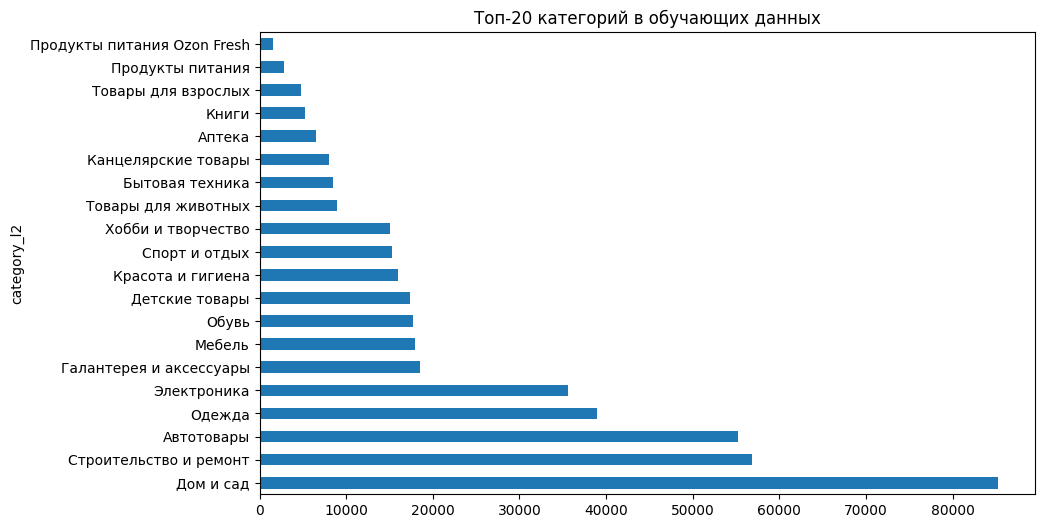

In [5]:
# 2. ЗАГРУЗКА ДАННЫХ
# ======================
print("⏳ Загрузка данных...")
train_data = pd.read_parquet("/content/sample_data/hackaton_train_types_recom.parquet")
test_data = pd.read_parquet("/content/sample_data/hackaton_test_types_recom.parquet")

# Визуализация распределения категорий
plt.figure(figsize=(10, 6))
train_data['category_l2'].value_counts()[:20].plot(kind='barh')
plt.title('Топ-20 категорий в обучающих данных')
plt.show()

In [6]:
# 2. ПРЕДОБРАБОТКА ДАННЫХ
# ======================
def remove_duplicates_with_report(df, df_name=""):
    """Удаляет дубликаты и выводит отчет"""
    initial_len = len(df)
    duplicates = df[df.duplicated(keep='first')]
    dup_count = len(duplicates)

    if dup_count > 0:
        print(f"\n🔍 Найдено дубликатов в {df_name}: {dup_count} ({dup_count/initial_len:.1%})")
        print("Распределение по категориям:")
        print(duplicates['category_l2'].value_counts().head(10))
        df = df.drop_duplicates()
        print(f"Оставлено записей: {len(df)} (удалено {dup_count})")
    else:
        print(f"\n✅ В {df_name} дубликатов не найдено")

    return df

print("\n🧹 Очистка данных...")

# Фильтрация по target
train_data = train_data[train_data["target"] == 1]
test_data = test_data[test_data["target"] == 1]

# Удаление дубликатов
train_data = remove_duplicates_with_report(train_data, "тренировочных данных")
test_data = remove_duplicates_with_report(test_data, "тестовых данных")

# Очистка текста
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # Удаляем пунктуацию
    text = re.sub(r'\d+', '', text)      # Удаляем цифры
    return text.strip()

train_data["clean_name"] = train_data["name"].apply(preprocess_text)
test_data["clean_name"] = test_data["name"].apply(preprocess_text)

# Кодирование категорий
le = LabelEncoder()
train_data["category_encoded"] = le.fit_transform(train_data["category_l2"])
test_data["category_encoded"] = le.transform(test_data["category_l2"])


🧹 Очистка данных...

🔍 Найдено дубликатов в тренировочных данных: 46533 (12.1%)
Распределение по категориям:
category_l2
Дом и сад                      13057
Строительство и ремонт         10222
Одежда                          7483
Обувь                           4259
Галантерея и аксессуары         3451
Мебель                          2148
Электроника                     1035
Автотовары                       815
Продукты питания Ozon Fresh      790
Спорт и отдых                    706
Name: count, dtype: int64
Оставлено записей: 337373 (удалено 46533)

🔍 Найдено дубликатов в тестовых данных: 5049 (5.3%)
Распределение по категориям:
category_l2
Строительство и ремонт         1519
Дом и сад                      1057
Одежда                          758
Обувь                           429
Галантерея и аксессуары         427
Мебель                          211
Продукты питания Ozon Fresh     142
Электроника                      97
Спорт и отдых                    86
Автотовары            

In [7]:
# 3. ВЕКТОРИЗАЦИЯ ТЕКСТА
# ======================
print("\n🔠 Векторизация текста...")
tfidf = TfidfVectorizer(
    max_features=15000,
    stop_words=stopwords.words('russian'),
    ngram_range=(1, 2),
    min_df=3
)

X_train = tfidf.fit_transform(train_data["clean_name"])
X_test = tfidf.transform(test_data["clean_name"])
y_train = train_data["category_encoded"]
y_test = test_data["category_encoded"]


🔠 Векторизация текста...


In [10]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 23.7 MB/s eta 0:00:00


In [11]:
# 4. ОПТИМИЗАЦИЯ С OPTUNA
# ========================
from sklearn.metrics import accuracy_score
import optuna
from optuna.samplers import TPESampler
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'verbosity': -1  # Добавляем управление логгированием через этот параметр
    }

    model = LGBMClassifier(**params, random_state=42)

    X_train_sub, X_val, y_train_sub, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    model.fit(
        X_train_sub, y_train_sub,
        eval_set=[(X_val, y_val)],
        callbacks=[
            early_stopping(50),
            log_evaluation(0)  # 0 означает отсутствие логов
        ]
        # Убрали параметр verbose
    )

    y_pred = model.predict(X_val)
    return accuracy_score(y_val, y_pred)
print("\n🔎 Оптимизация гиперпараметров (может занять время)...")
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner()
)
study.optimize(objective, n_trials=50, timeout=7200)

print("\n🏆 Лучшие параметры:")
for key, value in study.best_params.items():
    print(f"{key:>20}: {value}")
print(f"\nBest accuracy: {study.best_value:.4f}")

[I 2025-07-30 07:31:27,797] A new study created in memory with name: no-name-ddda9c0e-7298-4284-975f-93c429b8446e



🔎 Оптимизация гиперпараметров (может занять время)...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[574]	valid_0's multi_logloss: 0.695273


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-30 07:46:02,633] Trial 0 finished with value: 0.7955390885513153 and parameters: {'n_estimators': 574, 'learning_rate': 0.2536999076681772, 'num_leaves': 115, 'max_depth': 8, 'min_child_samples': 19, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.7955390885513153.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1170]	valid_0's multi_logloss: 0.650868


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-30 07:53:14,321] Trial 1 finished with value: 0.803052982586143 and parameters: {'n_estimators': 1170, 'learning_rate': 0.16967533607196555, 'num_leaves': 47, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.7216968971838151, 'colsample_bytree': 0.8099025726528951, 'reg_alpha': 4.319450186421157, 'reg_lambda': 2.9122914019804194, 'boosting_type': 'gbdt'}. Best is trial 1 with value: 0.803052982586143.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid_0's multi_logloss: 0.741148


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-30 08:01:05,547] Trial 2 finished with value: 0.7826157836235643 and parameters: {'n_estimators': 492, 'learning_rate': 0.03476649150592621, 'num_leaves': 79, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.8056937753654446, 'colsample_bytree': 0.836965827544817, 'reg_alpha': 0.46450412719997725, 'reg_lambda': 6.075448519014383, 'boosting_type': 'gbdt'}. Best is trial 1 with value: 0.803052982586143.
/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-0

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[459]	valid_0's multi_logloss: 0.772309


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-30 08:57:12,951] Trial 4 finished with value: 0.776494998147462 and parameters: {'n_estimators': 459, 'learning_rate': 0.09519754482692679, 'num_leaves': 60, 'max_depth': 8, 'min_child_samples': 57, 'subsample': 0.6739417822102108, 'colsample_bytree': 0.9878338511058234, 'reg_alpha': 7.7513282336111455, 'reg_lambda': 9.394989415641891, 'boosting_type': 'gbdt'}. Best is trial 3 with value: 0.8035124120044461.
/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07


🏆 Лучшие параметры:
        n_estimators: 1149
       learning_rate: 0.26690431824362526
          num_leaves: 125
           max_depth: 6
   min_child_samples: 14
           subsample: 0.8736932106048627
    colsample_bytree: 0.7760609974958406
           reg_alpha: 1.2203823484477883
          reg_lambda: 4.951769101112702
       boosting_type: dart

Best accuracy: 0.8035


In [12]:
# 5. ФИНАЛЬНАЯ МОДЕЛЬ
# ====================
print("\n🤖 Обучение финальной модели...")
best_params = study.best_params
final_model = LGBMClassifier(**best_params, random_state=42)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[early_stopping(50), log_evaluation(50)]
)



🤖 Обучение финальной модели...


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	valid_0's multi_logloss: 0.890203
[100]	valid_0's multi_logloss: 0.843874
[150]	valid_0's multi_logloss: 0.823006
[200]	valid_0's multi_logloss: 0.81443
[250]	valid_0's multi_logloss: 0.779941
[300]	valid_0's multi_logloss: 0.75966
[350]	valid_0's multi_logloss: 0.744844
[400]	valid_0's multi_logloss: 0.73945
[450]	valid_0's multi_logloss: 0.736861
[500]	valid_0's multi_logloss: 0.711477
[550]	valid_0's multi_logloss: 0.703483
[600]	valid_0's multi_logloss: 0.697199
[650]	valid_0's multi_logloss: 0.680451
[700]	valid_0's multi_logloss: 0.670351
[750]	valid_0's multi_logloss: 0.65845
[800]	valid_0's multi_logloss: 0.65116
[850]	valid_0's multi_logloss: 0.640756
[900]	valid_0's multi_logloss: 0.636367
[950]	valid_0's multi_logloss: 0.636482
[1000]	valid_0's multi_logloss: 0.629883
[1050]	valid_0's multi_logloss: 0.626028
[1100]	valid_0's multi_logloss: 0.616879


LGBMClassifier(boosting_type='dart', colsample_bytree=0.7760609974958406,
               learning_rate=0.26690431824362526, max_depth=6,
               min_child_samples=14, n_estimators=1149, num_leaves=125,
               random_state=42, reg_alpha=1.2203823484477883,
               reg_lambda=4.951769101112702, subsample=0.8736932106048627)

In [13]:
# 6. ОЦЕНКА И СОХРАНЕНИЕ
# ========================
print("\n📊 Оценка модели...")
y_pred = final_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\nConfusion Matrix (топ-10 категорий):")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_[:10]
)
fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("Матрица ошибок (топ-10 категорий)")
plt.tight_layout()
plt.show()

print("\n💾 Сохранение артефактов...")
joblib.dump(final_model, 'best_lgbm_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(le, 'label_encoder.pkl')

print("\n✅ Готово! Модель сохранена в best_lgbm_model.pkl")


📊 Оценка модели...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Classification Report:


TypeError: object of type 'NoneType' has no len()

In [14]:
# 1. Убедимся, что LabelEncoder правильно обучен
le = LabelEncoder()
y_train_encoded = le.fit_transform(train_data["category_l2"])
y_test_encoded = le.transform(test_data["category_l2"])

# 2. Проверим, что классы существуют
print("Классы в LabelEncoder:", le.classes_)

# 3. Исправленный вывод classification_report
try:
    print("\nClassification Report:")
    print(classification_report(
        y_test_encoded,
        y_pred,
        target_names=le.classes_.astype(str)  # Явное преобразование в строку
    ))
except Exception as e:
    print("\nОшибка при выводе отчета:", e)
    print("Простой отчет без имен классов:")
    print(classification_report(y_test_encoded, y_pred))

Классы в LabelEncoder: ['Автомототехника' 'Автотовары' 'Антиквариат и коллекционирование'
 'Аптека' 'Бытовая техника' 'Бытовая химия' 'Галантерея и аксессуары'
 'Детские товары' 'Дом и сад' 'Канцелярские товары'
 'Кино, музыка, видеоигры, софт' 'Книги' 'Красота и гигиена' 'Мебель'
 'Музыкальные инструменты' 'Обувь' 'Одежда' 'Продукты питания'
 'Продукты питания Ozon Fresh' 'Спорт и отдых' 'Строительство и ремонт'
 'Товары для взрослых' 'Товары для животных'
 'Товары для курения и аксессуары' 'Фермерское хозяйство'
 'Хобби и творчество' 'Электроника' 'Ювелирные изделия' None]

Classification Report:
                                  precision    recall  f1-score   support

                 Автомототехника       1.00      0.88      0.94        25
                      Автотовары       0.95      0.87      0.91      8933
Антиквариат и коллекционирование       0.69      0.37      0.48       117
                          Аптека       0.77      0.36      0.49       540
                 Бытова

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
import numpy as np

In [16]:
y_proba = final_model.predict_proba(X_test)  # (n_samples, n_classes)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [17]:
lb = LabelBinarizer()
y_test_onehot = lb.fit_transform(y_test_encoded)  # (n_samples, n_classes)

In [18]:
roc_auc_ovr = roc_auc_score(
    y_test_onehot,
    y_proba,
    multi_class="ovr",  # стратегия "one-vs-rest"
    average="weighted"  # учитывает дисбаланс классов (можно "macro")
)
print(f"ROC AUC (weighted, OvR): {roc_auc_ovr:.4f}")

ROC AUC (weighted, OvR): 0.9690


<Figure size 1000x800 with 0 Axes>

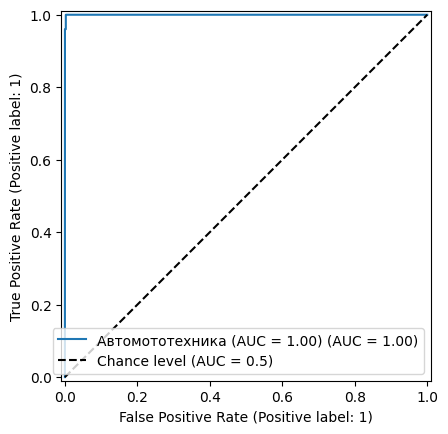

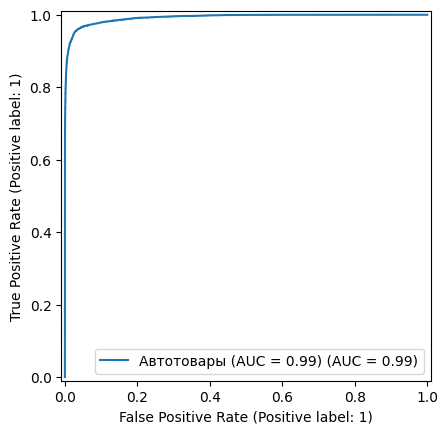

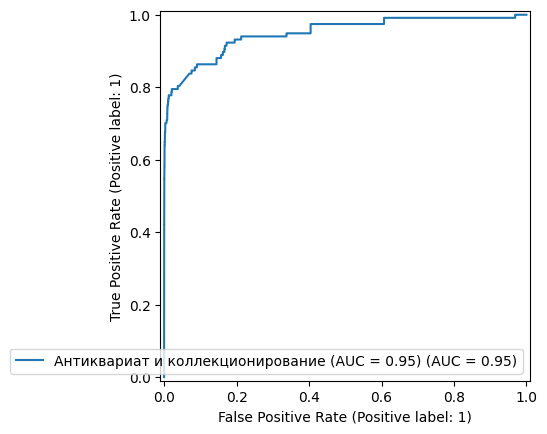

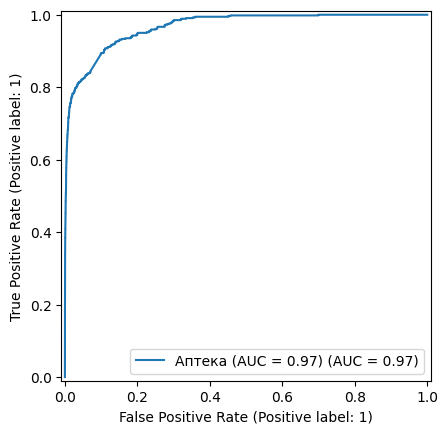

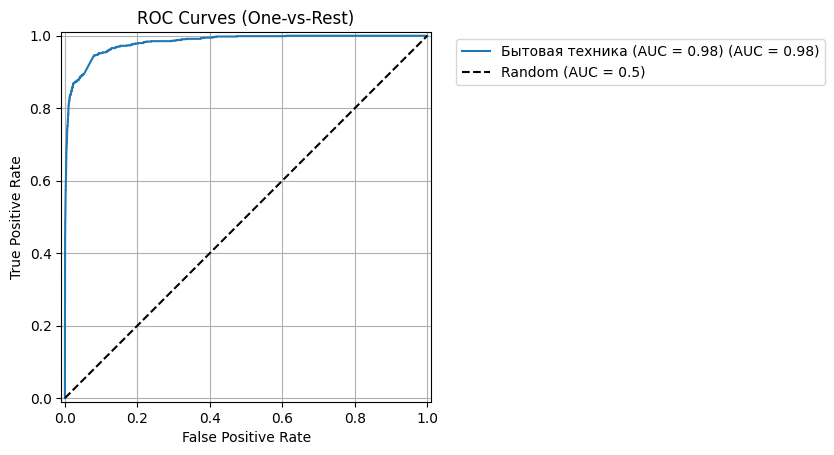

In [19]:
n_classes = len(le.classes_)
plt.figure(figsize=(10, 8))

# Отрисовка ROC-кривых для первых 5 классов (для наглядности)
for i in range(min(5, n_classes)):
    RocCurveDisplay.from_predictions(
        y_test_onehot[:, i],
        y_proba[:, i],
        name=f"{le.classes_[i]} (AUC = {roc_auc_score(y_test_onehot[:, i], y_proba[:, i]):.2f})",
        plot_chance_level=(i == 0)  # Добавить пунктирную линию только для первого класса
    )

plt.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.show()

In [20]:
print("\nROC AUC по классам:")
for i, class_name in enumerate(le.classes_):
    auc = roc_auc_score(y_test_onehot[:, i], y_proba[:, i])
    print(f"{class_name}: {auc:.4f}")


ROC AUC по классам:
Автомототехника: 0.9999
Автотовары: 0.9925
Антиквариат и коллекционирование: 0.9493
Аптека: 0.9671
Бытовая техника: 0.9817
Бытовая химия: 0.9802
Галантерея и аксессуары: 0.9918
Детские товары: 0.9756
Дом и сад: 0.9898
Канцелярские товары: 0.9793
Кино, музыка, видеоигры, софт: 0.9924
Книги: 0.9866
Красота и гигиена: 0.9790
Мебель: 0.9979
Музыкальные инструменты: 0.9660
Обувь: 0.9989
Одежда: 0.9952
Продукты питания: 0.9874
Продукты питания Ozon Fresh: 0.9828
Спорт и отдых: 0.9591
Строительство и ремонт: 0.9870
Товары для взрослых: 0.9938
Товары для животных: 0.9874
Товары для курения и аксессуары: 0.9855
Фермерское хозяйство: 0.9574
Хобби и творчество: 0.9736
Электроника: 0.9820
Ювелирные изделия: 0.9994
None: 0.9152
